In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import multiprocessing
from tqdm import tqdm
import time

In [2]:
import os
from pathlib import Path
import pandas as pd
import kagglehub as kh

# 1) Download locally; this returns the root folder path
root = kh.dataset_download("daveianhickey/2000-16-traffic-flow-england-scotland-wales")
print("Dataset root:", root)

# 2) See what files are available
csvs = list(Path(root).rglob("*.csv"))
for i, p in enumerate(csvs[:15], 1):
    print(i, p.relative_to(root))  # peek at a few CSVs

# 3) Pick one and load it
target = Path(root) / "accidents_2005_to_2007.csv"   # <- adjust if you pick a different file
accidentdf = pd.read_csv(target, low_memory=False)
# print(df.shape)
# df.head()


/home/gdyang/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset root: /home/gdyang/.cache/kagglehub/datasets/daveianhickey/2000-16-traffic-flow-england-scotland-wales/versions/10
1 accidents_2005_to_2007.csv
2 ukTrafficAADF.csv
3 accidents_2012_to_2014.csv
4 accidents_2009_to_2011.csv


In [3]:
accidentdf1 = pd.read_csv(Path(root) / "accidents_2005_to_2007.csv" ,low_memory = False)
accidentdf2 = pd.read_csv(Path(root) / "accidents_2009_to_2011.csv",low_memory = False)
accidentdf3 = pd.read_csv(Path(root) / "accidents_2012_to_2014.csv",low_memory = False)

df_concat = pd.concat([accidentdf1, accidentdf2, accidentdf3])
print("Done")

Done


In [4]:
df = df_concat.drop(columns = ['Accident_Index','Location_Easting_OSGR',
                            'Location_Northing_OSGR','Date','LSOA_of_Accident_Location',
                            'Local_Authority_(District)','Local_Authority_(Highway)',
                            '1st_Road_Number','Longitude','Latitude',
                            '1st_Road_Class', 'Road_Type',
                            'Police_Force','Junction_Detail',
                            '2nd_Road_Class','2nd_Road_Number'
                            ])

# print(df.info())
df['Junction_Control'] = df['Junction_Control'].fillna('No junction')
df['Light_Conditions'] = df['Light_Conditions'].replace(
    {'Darkeness: No street lighting': 'Darkness: No street lighting'}
)
df['Special_Conditions_at_Site'] = df['Special_Conditions_at_Site'].fillna('None')
df['Carriageway_Hazards'] = df['Carriageway_Hazards'].fillna('None')


df = df.dropna()

scaler = sk.preprocessing.StandardScaler()
df[['Number_of_Vehicles', 'Number_of_Casualties']] = scaler.fit_transform(df[['Number_of_Vehicles', 'Number_of_Casualties']])

df = pd.get_dummies(df, columns = ['Day_of_Week', 'Time', 'Speed_limit', 'Junction_Control', 'Pedestrian_Crossing-Human_Control',
                                   'Road_Surface_Conditions', 'Pedestrian_Crossing-Physical_Facilities',
                                'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 
                                'Carriageway_Hazards', 'Urban_or_Rural_Area',
                               'Did_Police_Officer_Attend_Scene_of_Accident', 'Year'])
print("Done")

Done


In [11]:
pca = sk.decomposition.PCA(n_components=2)
transform = pca.fit_transform(df)
print(transform)

[[-1.03355206 -1.7094473 ]
 [-1.31779762  0.33260816]
 [-0.31086358  0.5646711 ]
 ...
 [-0.80245647 -1.24559904]
 [ 2.08764396 -1.50706093]
 [ 1.1020362  -1.32068874]]


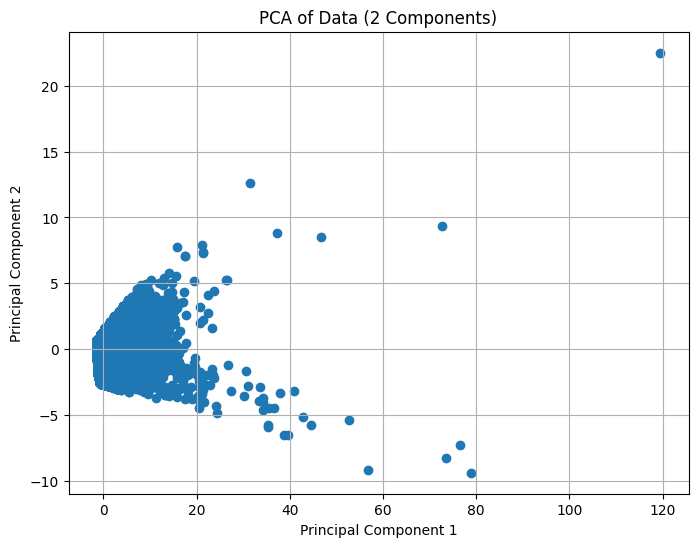

In [14]:
df_pca = pd.DataFrame(data = transform, columns = ['PC1', 'PC2'])

# Plot the 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Data (2 Components)')
plt.grid(True)
plt.show()

In [27]:
kmeans = sk.cluster.KMeans(n_clusters=3, random_state=0, n_init="auto").fit(df_pca)

y = kmeans.predict(df_pca)
centroids = kmeans.cluster_centers_
print(centroids)

[[-0.41907485  0.5956835 ]
 [-0.13674778 -1.31667327]
 [ 2.03316576  0.1571136 ]]


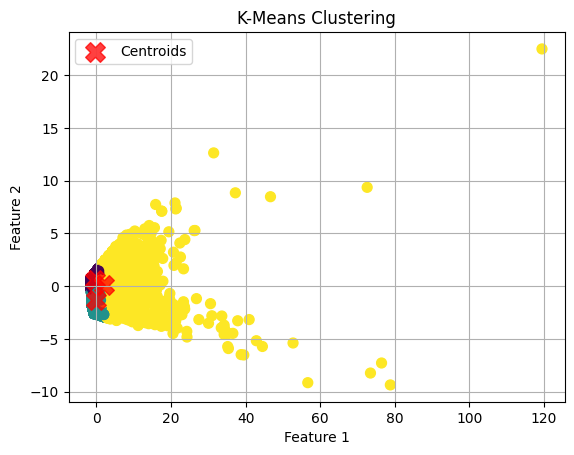

In [28]:
np_pca = df_pca.to_numpy()
plt.scatter(np_pca[:, 0], np_pca[:, 1], c=y, s=50, cmap='viridis')

plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Centroids')

plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

plt.show()